# 嵌入层

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

如今，我们使用一组one-hot编码来表示文本，它是一个n维数组，其中每个索引对应一个词条（token）。该索引处的值与该单词在句子中出现的次数相对应。这种方法使得我们完全丢失输入文本中的结构性信息。

```python
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]```

 我们还用一种one-hot编码来表示输入，其中每个词条由一个n维数组表示。
 
 ```python
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
```

这种表示方式允许我们保存结构性信息，但有两个主要缺点。如果我们有一个很大的词汇表，每个词条标记的表示长度将是巨大的，从而导致大量计算。虽然我们保留了文本中的结构信息，但是每个词条的实际表示并没有保留着与其他词条的关系。

在本节笔记中，我们将学习嵌入层以及它们是如何解决我们目前各种表示方法的不足之处。





# 概述

* **目标：**表示文本中包含内在语义关系的词条。
* **优点：**
    * 捕捉关系的同时保持低维度
    * 可解释的词条表示
* **缺点：**
    * 没有
* **其他方面：**有许多预训练好的嵌入层可供选择，但是您也可以从头开始训练自己的嵌入层。
    


# 嵌入层学习

嵌入层的主要思想是为文本中的词条提供固定长度的表示，而不考虑词汇表中的词条数量。因此，每个词条的表示形式的形状不再是[1 X V]（V是词汇表的大小），而是[1 X D]（D是嵌入层大小(通常为50,100,200,300)）。表示中的数字不再是0和1，而是在D维潜在空间中表示该词条的浮点小数。如果嵌入层确实捕获了词条之间的关系，那么我们应该能够发现这个潜在空间并确认已知的关系(我们很快就会这么做)。

但是我们首先应该如何学习嵌入层呢?嵌入层的直观解释是，词条的定义不取决于词条本身，而是取决于它的上下文。下面有几种不同的做法:

1. 给定上下文中的单词，预测目标单词(CBOW模型 -连续词袋)。
2. 给定目标词，预测上下文单词（除中心单词外窗口内的其他单词）(skip-gram模型)。
3. 给定一个单词序列，预测下一个单词(LM语言建模)。

这些方法都涉及到创建数据来训练我们的模型。句子中的每个词都成为目标词，上下文词由一个窗口决定。在下面的图(skip-gram)中，窗口大小为2。我们对语料库中的每个句子都重复这个过程，这就产生了针对非监督任务的训练数据。这是一种无监督学习技术，因为我们没有正式的上下文标签。我们的想法是，相似的目标词会出现在相似的语境中，我们可以通过反复训练这种匹配模式(上下文，目标)来学习这种关系。

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/skipgram.png" width=600>

我们可以使用上述任何一种方法学习嵌入层，各有优劣。确认用哪种方法的最佳方式是验证它在有监督任务上的性能表现。我们可以通过在PyTorch中创建模型来学习嵌入层，但是这里我们将使用一个专门用于嵌入层和主题建模的库[Gensim](https://radimrehurek.com/gensim/)。

In [3]:
!pip install gensim 

In [4]:
import os
from argparse import Namespace
import copy
import gensim
from gensim.models import Word2Vec
import json
import nltk; nltk.download('punkt')
import numpy as np
import pandas as pd
import re
import urllib
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
args = Namespace(
    seed=1234,
    data_file="harrypotter.txt",
    embedding_dim=100,
    window=5,
    min_count=3,
    skip_gram=1, # 0 = CBOW
    negative_sampling=20,
)

In [0]:
# 将数据从github上更新到本地notebook
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/harrypotter.txt"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [7]:
# 将文本分割成每个句子
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
with open(args.data_file, encoding='cp1252') as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)
print (len(sentences))
print (sentences[11])

15640
Snape nodded, but did not elaborate.


In [0]:
# 数据预处理
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = text.strip()
    return text

In [9]:
# 对句子进行数据清洗
sentences = [preprocess_text(sentence) for sentence in sentences]
print (sentences[11])

snape nodded , but did not elaborate .


In [10]:
# 为gensim对句子进行预处理
sentences = [sentence.split(" ") for sentence in sentences]
print (sentences[11])

['snape', 'nodded', ',', 'but', 'did', 'not', 'elaborate', '.']


当我们有大型的词汇表去学习嵌入层时，事情很快就会变得复杂起来。回想一下，softmax的反向传播更新了正确类和错误类的权重。对于每一次的回传，都需要大量的计算，所以解决方法是使用负采样，它只需要更新正确类和一些随机的错误类(negative_sampling=20)。我们之所以能够这样做，是因为我们有大量的训练数据，在这些数据中，我们将多次看到与目标类相同的单词。



In [11]:
# 由于底层是C语言写的所以速度非常快
model = Word2Vec(sentences=sentences, size=args.embedding_dim, 
                 window=args.window, min_count=args.min_count, 
                 sg=args.skip_gram, negative=args.negative_sampling)
print (model)

Word2Vec(vocab=4837, size=100, alpha=0.025)


In [12]:
# 将每个词进行向量化
model.wv.get_vector("potter")

array([ 0.57121795, -0.4473022 , -0.24764916, -0.02014627,  0.21817273,
       -0.17684223,  0.0971131 , -0.22699513, -0.44662133,  0.34343132,
       -0.43126193,  0.14076817, -0.30172673, -0.34286836, -0.01562079,
       -0.1676844 ,  0.10327088, -0.27377397,  0.21167807,  0.00207133,
        0.08535747,  0.09200649,  0.31590024, -0.00346842, -0.0040499 ,
        0.05679551, -0.03496649,  0.12977482,  0.5481599 , -0.05868822,
        0.22223113, -0.65511256, -0.22511719,  0.01033045, -0.47850764,
        0.27103794,  0.22211818,  0.05265665,  0.08114785, -0.10955557,
       -0.23463504,  0.05834079,  0.38490152,  0.3176595 , -0.04837222,
       -0.07741249,  0.08143531,  0.08240102,  0.23861782, -0.15033284,
       -0.37583345,  0.5298492 , -0.27770242, -0.02436154,  0.6498464 ,
        0.15981446, -0.08876655, -0.11807754,  0.04486049, -0.08496018,
        0.5243146 ,  0.05710106,  0.0346731 , -0.50119925,  0.1966134 ,
       -0.046356  , -0.22535692,  0.15454814,  0.20338546, -0.16

In [13]:
# 找到距离最近的单词(不包括自己)
model.wv.most_similar(positive="scar", topn=5)

[('pain', 0.9411180019378662),
 ('forehead', 0.9267646074295044),
 ('prickling', 0.9210630059242249),
 ('mouth', 0.9191247820854187),
 ('burning', 0.9186864495277405)]

In [0]:
# 保存权重值
model.wv.save_word2vec_format('model.txt', binary=False)

# 预训练嵌入层

我们可以使用上面的任意一种方法从头开始学习嵌入层，另外我们也可以使用已经在数百万文档上经过训练的预训练嵌入层。目前流行的嵌入层包括Word2Vec (skip-gram)或GloVe (global word-word co-occurrence)。我们可以通过确认这些嵌入层捕获的有意义的语义关系来进行验证操作。

In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from zipfile import ZipFile
from urllib.request import urlopen

In [16]:
# 解压缩文件（大约3分钟）
resp = urlopen('http://nlp.stanford.edu/data/glove.6B.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [17]:
# 写入嵌入层
embeddings_file = 'glove.6B.{0}d.txt'.format(args.embedding_dim)
zipfile.extract(embeddings_file)

'/content/glove.6B.100d.txt'

In [18]:
# 保存word2vec格式的GloVe嵌入层到本地词典
word2vec_output_file = '{0}.word2vec'.format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

(400000, 100)

In [0]:
# 读取嵌入层（大约一分钟）
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [20]:
# (king - man) + woman = ?
glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438)]

In [21]:
# 找到距离最近的单词(不包括自己)
glove.wv.most_similar(positive="goku", topn=5)

[('gohan', 0.7246542572975159),
 ('bulma', 0.6497020125389099),
 ('raistlin', 0.6443604230880737),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [0]:
# 降维方便绘图
X = glove[glove.wv.vocab]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

In [0]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index2word.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

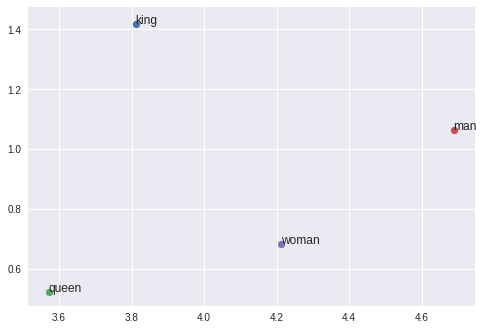

In [24]:
plot_embeddings(words=["king", "queen", "man", "woman"], embeddings=glove, 
                pca_results=pca_results)

In [25]:
# 输出嵌入层的偏差
glove.most_similar(positive=['woman', 'doctor'], negative=['man'], topn=5)

[('nurse', 0.7735227346420288),
 ('physician', 0.7189429998397827),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033687591553)]

# 使用嵌入层

下面有几种不同的方法去使用嵌入层:

1.   使用自己训练的嵌入层（在非监督数据集上训练）
2.   使用预训练的嵌入层（GlioVe，word2vec等）
3.   随机初始化的嵌入层

一旦你确定使用嵌入层，你可以在使用监督数据训练的时候，选择冻结（freeze）还是继续（这可能会导致过拟合）。在本例中，我们将使用GloVe嵌入层并且在训练的时候冻结它。我们这次的任务是预测给定标题的文章类型。


## 设置

In [26]:
# 读取PyTorch库
!pip3 install torch

    100% |████████████████████████████████| 591.8MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x620e2000 @  0x7fc78e7402a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import os
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [0]:
# 设置Numpy和PyTorch的种子
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# 创建目录
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [29]:
# 配置参数
args = Namespace(
    seed=1234,
    cuda=True,
    shuffle=True,
    data_file="news.csv",
    split_data_file="split_news.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="news",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    cutoff=25, # 词条必须出现至少<cutoff>次才能出现在SequenceVocabulary类
    num_epochs=5,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    num_filters=100,
    embedding_dim=100,
    hidden_dim=100,
    dropout_p=0.1,
)

# 设置种子
set_seeds(seed=args.seed, cuda=args.cuda)

# 创建保存目录
create_dirs(args.save_dir)

# 拓展文件路径
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# 检查CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: True


## 数据

In [0]:
import re
import urllib

In [0]:
# 将数据从github上更新到本地notebook
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [32]:
# 原始数据
df = pd.read_csv(args.data_file, header=0)
df.head()

,category,title
0,Business,Wall St. Bears Claw Back Into the Black (Reuters)
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [33]:
# 按类别划分
by_category = collections.defaultdict(list)
for _, row in df.iterrows():
    by_category[row.category].append(row.to_dict())
for category in by_category:
    print ("{0}: {1}".format(category, len(by_category[category])))

Business: 30000
Sci/Tech: 30000
Sports: 30000
World: 30000


In [0]:
# 创建划分数据集
final_list = []
for _, item_list in sorted(by_category.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # 给数据指定一个划分属性
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # 添加到最终列表
    final_list.extend(item_list)

In [35]:
# 将划分数据集转化为pandas格式
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    84000
test     18000
val      18000
Name: split, dtype: int64

In [0]:
# 数据预处理
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
split_df.title = split_df.title.apply(preprocess_text)

In [37]:
# 保存为CSV格式
split_df.to_csv(args.split_data_file, index=False)
split_df.head()

,category,split,title
0,Business,train,general electric posts higher rd quarter profit
1,Business,train,lilly to eliminate up to us jobs
2,Business,train,s amp p lowers america west outlook to negative
3,Business,train,does rand walk the talk on labor policy ?
4,Business,train,housekeeper advocates for changes


## 词汇表

In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # 词条转换为索引
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # 索引转换为词条
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

## 序列词汇表

In [39]:
# 词汇表实例
category_vocab = Vocabulary()
for index, row in df.iterrows():
    category_vocab.add_token(row.category)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
index = category_vocab.lookup_token("Business")
print (index)
print (category_vocab.lookup_index(index))

<Vocabulary(size=4)>
4
0
Business


下面，我们将为文章标题创建词汇表类，由一系列词条构成。

In [0]:
from collections import Counter
import string

In [0]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self.mask_token = mask_token
        self.unk_token = unk_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token

        self.mask_index = self.add_token(self.mask_token)
        self.unk_index = self.add_token(self.unk_token)
        self.begin_seq_index = self.add_token(self.begin_seq_token)
        self.end_seq_index = self.add_token(self.end_seq_token)
        
        # 索引转换为词条
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'mask_token': self.mask_token,
                         'begin_seq_token': self.begin_seq_token,
                         'end_seq_token': self.end_seq_token})
        return contents

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)
    
    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the SequenceVocabulary" % index)
        return self.idx_to_token[index]
    
    def __str__(self):
        return "<SequenceVocabulary(size=%d)>" % len(self.token_to_idx)

    def __len__(self):
        return len(self.token_to_idx)


In [42]:
# 得到单词长度
word_counts = Counter()
for title in split_df.title:
    for token in title.split(" "):
        if token not in string.punctuation:
            word_counts[token] += 1

# 创建SequenceVocabulary实例
title_vocab = SequenceVocabulary()
for word, word_count in word_counts.items():
    if word_count >= args.cutoff:
        title_vocab.add_token(word)
print (title_vocab) # __str__
print (len(title_vocab)) # __len__
index = title_vocab.lookup_token("general")
print (index)
print (title_vocab.lookup_index(index))

<SequenceVocabulary(size=4400)>
4400
4
general


## 向量化

In [0]:
class NewsVectorizer(object):
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title):
        indices = [self.title_vocab.lookup_token(token) for token in title.split(" ")]
        indices = [self.title_vocab.begin_seq_index] + indices + \
            [self.title_vocab.end_seq_index]
        
        # 创建向量
        title_length = len(indices)
        vector = np.zeros(title_length, dtype=np.int64)
        vector[:len(indices)] = indices

        return vector
    
    def unvectorize(self, vector):
        tokens = [self.title_vocab.lookup_index(index) for index in vector]
        title = " ".join(token for token in tokens)
        return title

    @classmethod
    def from_dataframe(cls, df, cutoff):
        
        # 创建类别词表
        category_vocab = Vocabulary()        
        for category in sorted(set(df.category)):
            category_vocab.add_token(category)

        # 获取词长度
        word_counts = Counter()
        for title in df.title:
            for token in title.split(" "):
                word_counts[token] += 1
        
        # 创建标题词表
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(title_vocab=title_vocab, category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

In [44]:
# 向量化实例
vectorizer = NewsVectorizer.from_dataframe(split_df, cutoff=args.cutoff)
print (vectorizer.title_vocab)
print (vectorizer.category_vocab)
vectorized_title = vectorizer.vectorize(preprocess_text(
    "Roger Federer wins the Wimbledon tennis tournament."))
print (np.shape(vectorized_title))
print (vectorized_title)
print (vectorizer.unvectorize(vectorized_title))

<SequenceVocabulary(size=4405)>
<Vocabulary(size=4)>
(11,)
[   2    1 4152 1232   25    1 2393 4077   39   31    3]
<BEGIN> <UNK> federer wins the <UNK> tennis tournament .  <END>


## 数据集

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class NewsDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer
        
        # 最大的标题长度
        get_length = lambda title: len(title.split(" "))
        self.max_seq_length = max(map(get_length, df.title)) + 2 # (<BEGIN> + <END>)

        # 数据划分
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # 类权重（用于样本失衡）
        class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, split_data_file, cutoff):
        df = pd.read_csv(split_data_file, header=0)
        train_df = df[df.split=='train']
        return cls(df, NewsVectorizer.from_dataframe(train_df, cutoff))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, split_data_file, vectorizer_filepath):
        df = pd.read_csv(split_data_file, header=0)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NewsVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        title_vector = self.vectorizer.vectorize(row.title)
        category_index = self.vectorizer.category_vocab.lookup_token(row.category)
        return {'title': title_vector, 'category': category_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, collate_fn, shuffle=True, 
                         drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size,
                                collate_fn=collate_fn, shuffle=shuffle, 
                                drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [47]:
# 数据集实例
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file, 
                                                       cutoff=args.cutoff)
print (dataset) # __str__
title_vector = dataset[5]['title'] # __getitem__
print (title_vector)
print (dataset.vectorizer.unvectorize(title_vector))
print (dataset.class_weights)

<Dataset(split=train, size=84000)
[ 2 32 33 10 34 13  3]
<BEGIN> software firm to cut jobs <END>
tensor([3.3333e-05, 3.3333e-05, 3.3333e-05, 3.3333e-05])


## 模型

input（输入层） → embedding（嵌入层） → conv （卷积层）→ FC （全连接层）
我们将使用一维的卷积层计算 ([nn.Conv1D](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d))，尽管我们的输入是各个单词，但我们并不是使用字符级来表示它们，我们采用的输入层形状是shape $\in \mathbb{R}^{NXSXE}$
* 其中:
    * N = batchsize（每个批处理的训练样本数）
    * S = max sentence length （最大句子长度）
    * E = embedding dim at a word level（词嵌入维度）

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class NewsModel(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, num_input_channels, 
                 num_channels, hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(NewsModel, self).__init__()
        
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                          num_embeddings=num_embeddings,
                                          padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=num_embeddings,
                                           padding_idx=padding_idx,
                                           _weight=pretrained_embeddings)
        
        # 卷积层权重
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, num_channels, 
                                             kernel_size=f) for f in [2,3,4]])
     
        # 全连接层权重
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_channels*3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

    def forward(self, x_in, channel_first=False, apply_softmax=False):
        
        # 嵌入
        x_in = self.embeddings(x_in)

        # 重新调整输入层，使得通道数num_channels为一维（N,C,L）
        if not channel_first:
            x_in = x_in.transpose(1, 2)
            
        # 卷积层输出
        z1 = self.conv[0](x_in)
        z1 = F.max_pool1d(z1, z1.size(2)).squeeze(2)
        z2 = self.conv[1](x_in)
        z2 = F.max_pool1d(z2, z2.size(2)).squeeze(2)
        z3 = self.conv[2](x_in)
        z3 = F.max_pool1d(z3, z3.size(2)).squeeze(2)
        
        # 连接卷积层的输出
        z = torch.cat([z1, z2, z3], 1)

        # 全连接层
        z = self.dropout(z)
        z = self.fc1(z)
        y_pred = self.fc2(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

## 训练

In [0]:
import torch.optim as optim

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # 输出详细信息
        print ("[EPOCH]: {0:02d} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # 保存至少一个模型
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # 如果表现提高的话，再次保存模型
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # 如果损失无法收敛
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # 如果损失下降
            else:
                # 保存最佳模型
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # 重置early stopping step为0
                self.train_state['early_stopping_step'] = 0

            # 提前停止
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
    
    def pad_seq(self, seq, length):
        vector = np.zeros(length, dtype=np.int64)
        vector[:len(seq)] = seq
        vector[len(seq):] = self.dataset.vectorizer.title_vocab.mask_index
        return vector
    
    def collate_fn(self, batch):
        
        # 深拷贝
        batch_copy = copy.deepcopy(batch)
        processed_batch = {"title": [], "category": []}
        
        # 得到最长的序列长度
        max_seq_len = max([len(sample["title"]) for sample in batch_copy])
        
        # 数据填充
        for i, sample in enumerate(batch_copy):
            seq = sample["title"]
            category = sample["category"]
            padded_seq = self.pad_seq(seq, max_seq_len)
            processed_batch["title"].append(padded_seq)
            processed_batch["category"].append(category)
            
        # 转换为合适的张量数据类型
        processed_batch["title"] = torch.LongTensor(
            processed_batch["title"])
        processed_batch["category"] = torch.LongTensor(
            processed_batch["category"])
        
        return processed_batch    
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # 对训练集数据进行迭代

            # 初始化批处理生成器，设置loss和acc为0，设置为训练模式
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # 梯度置零
                self.optimizer.zero_grad()

                # 计算输出
                y_pred = self.model(batch_dict['title'])

                # 计算损失loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # 使用损失函数计算梯度
                loss.backward()

                # 使用优化器进行梯度计算
                self.optimizer.step()
                
                # 计算准确率accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # 对验证集数据进行迭代

            # 初始化批处理生成器，设置loss和acc为0，设置为验证模式
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # 计算输出
                y_pred =  self.model(batch_dict['title'])

                # 计算损失loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # 计算准确率accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # 初始化批处理生成器，设置loss和acc为0，设置为验证模式
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 计算输出
            y_pred =  self.model(batch_dict['title'])

            # 计算损失loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 计算准确率accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # 图片大小
        plt.figure(figsize=(15,5))

        # 绘制损失loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # 绘制准确率accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # 保存图片
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # 展示图片
        plt.show()
    
    def save_train_state(self):
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [52]:
# 初始化
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file, 
                                                       cutoff=args.cutoff)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=None, 
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3407, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [53]:
# 训练
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 0.79 | [TRAIN ACC]: 69.2% | [VAL LOSS]: 0.59 | [VAL ACC]: 78.5%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 0.50 | [TRAIN ACC]: 81.7% | [VAL LOSS]: 0.51 | [VAL ACC]: 81.7%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 0.42 | [TRAIN ACC]: 84.7% | [VAL LOSS]: 0.48 | [VAL ACC]: 82.7%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 0.36 | [TRAIN ACC]: 86.7% | [VAL LOSS]: 0.51 | [VAL ACC]: 82.5%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 0.32 | [TRAIN ACC]: 88.2% | [VAL LOSS]: 0.50 | [VAL ACC]: 82.5%


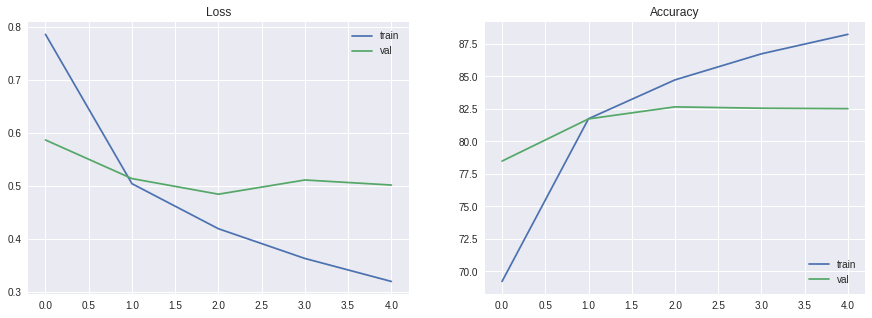

In [54]:
# 性能展示
trainer.plot_performance()

In [55]:
# 测试性能
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.50
Test Accuracy: 82.6%


In [0]:
# 保存所有结果
trainer.save_train_state()

## 使用GloVe嵌入层

We just used some randomly initialized embeddings and we were able to receive decent performance. Keep in mind that this may not always be the case and we may overfit on other datasets with this approach. We're now going to use pretrained GloVe embeddings to initialize our embeddings. We will train our model on the supervised task and assess the performance by first freezing these embeddings (so they don't change during training) and then not freezing them and allowing them to be trained. 

我们上面使用了一些随机初始化的嵌入层，获得还挺不错的性能。但是这种情况可能并不总是如此，而且我们使用这种方法在其他数据集可能会过拟合。现在我们要使用预训练好的GloVe嵌入层来初始化我们的嵌入层。我们将在监督任务上训练我们的模型，先冻结这些嵌入层(这样它们在训练期间就不会有任何变化)，然后解除冻结并允许它们进行训练，用这种方法来评估性能。

```python
pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
self.embeddings = nn.Embedding(embedding_dim=embedding_dim, 
                               num_embeddings=num_embeddings, 
                               padding_idx=padding_idx, 
                               _weight=pretrained_embeddings)
```

In [0]:
def load_glove_embeddings(embeddings_file):
    word_to_idx = {}
    embeddings = []

    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ")
            word = line[0]
            word_to_idx[word] = index
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)

    return word_to_idx, np.stack(embeddings)

def make_embeddings_matrix(words):
    word_to_idx, glove_embeddings = load_glove_embeddings(embeddings_file)
    embedding_dim = glove_embeddings.shape[1]
    embeddings = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in word_to_idx:
            embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.zeros(1, embedding_dim)
            nn.init.xavier_uniform_(embedding_i)
            embeddings[i, :] = embedding_i

    return embeddings

In [0]:
args.use_glove_embeddings = True

In [59]:
# 初始化
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file, 
                                                       cutoff=args.cutoff)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer

# 创建嵌入层
embeddings = None
if args.use_glove_embeddings:
    embeddings_file = 'glove.6B.{0}d.txt'.format(args.embedding_dim)
    words = vectorizer.title_vocab.token_to_idx.keys()
    embeddings = make_embeddings_matrix(words=words)
    print ("<Embeddings(words={0}, dim={1})>".format(
        np.shape(embeddings)[0], np.shape(embeddings)[1]))

<Embeddings(words=3407, dim=100)>


In [60]:
# 初始化模型
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=embeddings, 
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3407, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [61]:
# 训练
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 0.50 | [TRAIN ACC]: 81.9% | [VAL LOSS]: 0.44 | [VAL ACC]: 84.2%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 0.41 | [TRAIN ACC]: 85.2% | [VAL LOSS]: 0.45 | [VAL ACC]: 84.0%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 0.37 | [TRAIN ACC]: 86.6% | [VAL LOSS]: 0.44 | [VAL ACC]: 84.5%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 0.33 | [TRAIN ACC]: 87.8% | [VAL LOSS]: 0.44 | [VAL ACC]: 84.1%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 0.29 | [TRAIN ACC]: 89.3% | [VAL LOSS]: 0.47 | [VAL ACC]: 83.9%


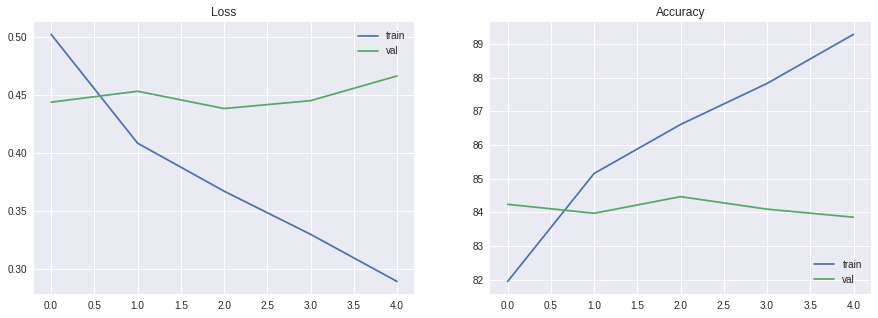

In [62]:
# 性能展示
trainer.plot_performance()

In [72]:
# 测试性能
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.2f}%".format(trainer.train_state['test_acc']))

Test loss: 0.45
Test Accuracy: 84.32%


In [0]:
# 保存所有结果
trainer.save_train_state()

## 冻结嵌入层

现在我们要冻结GloVe嵌入层并且在监督任务上进行训练。模型里唯一需要改变的是打开`freeze_embeddings`:

```python
if freeze_embeddings:
    self.embeddings.weight.requires_grad = False
```

In [0]:
args.freeze_embeddings = True

In [66]:
# 初始化模型
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=embeddings,
                  freeze_embeddings=args.freeze_embeddings,
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3407, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [67]:
# 训练
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 00 | [LR]: 0.001 | [TRAIN LOSS]: 0.53 | [TRAIN ACC]: 80.7% | [VAL LOSS]: 0.48 | [VAL ACC]: 82.6%
[EPOCH]: 01 | [LR]: 0.001 | [TRAIN LOSS]: 0.45 | [TRAIN ACC]: 83.7% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.3%
[EPOCH]: 02 | [LR]: 0.001 | [TRAIN LOSS]: 0.42 | [TRAIN ACC]: 85.0% | [VAL LOSS]: 0.45 | [VAL ACC]: 83.6%
[EPOCH]: 03 | [LR]: 0.001 | [TRAIN LOSS]: 0.39 | [TRAIN ACC]: 85.8% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.7%
[EPOCH]: 04 | [LR]: 0.001 | [TRAIN LOSS]: 0.36 | [TRAIN ACC]: 86.9% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.6%


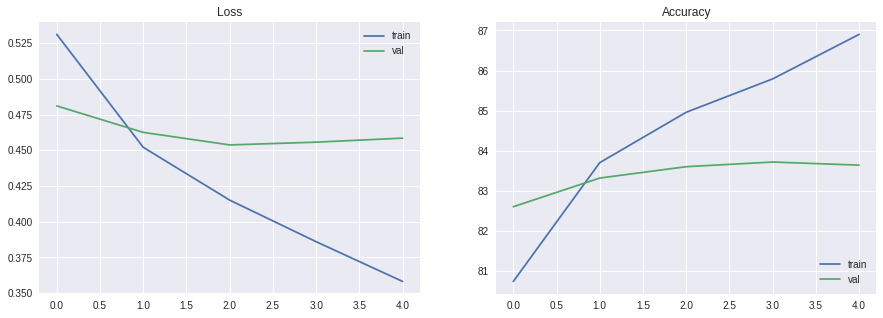

In [68]:
# 性能展示
trainer.plot_performance()

In [71]:
# 测试性能
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.2f}%".format(trainer.train_state['test_acc']))

Test loss: 0.45
Test Accuracy: 84.29%


In [0]:
# 保存所有结果
trainer.save_train_state()

通过对比我们可以发现，使用没有冻结的GloVe嵌入层在测试集上取得了最好的成绩。不同的任务会产生不同的结果，所以我们需要根据实验结论来选择是否使用冻结技术。

# TODO

* 什么时候使用skip-gram/CBOW
    * 根据Mikolov的观点：
    * Skip-gram：能够很好地处理少量的训练数据，甚至能很好地表示罕见的单词或短语。
    * CBOW：训练速度比skip-gram要快几倍，对频繁出现的单词的准确率高。
* 读取word2vec
* 可解释的卷积层过滤器（我们在处理单词的时候应用了conv卷积层）
* [基于上下文的词嵌入（contextualized word embeddings）](https://arxiv.org/abs/1607.00578)